book : [ https://otexts.com/fpp2/expsmooth-exercises.html]( https://otexts.com/fpp2/expsmooth-exercises.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller  # check stationarity
from statsmodels.tsa.arima.model import ARIMA  # model
from sklearn.metrics import mean_squared_error  # compute loss
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Using airline passengers dataset (monthly totals)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates = ['Month'], index_col = 'Month')
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [4]:
df.index.freq = "MS"  # MS stands for month start frequency

## Decomposition

In [5]:
from statsmodels.tsa.seasonal import STL

In [6]:
res = STL(df['Passengers']).fit()

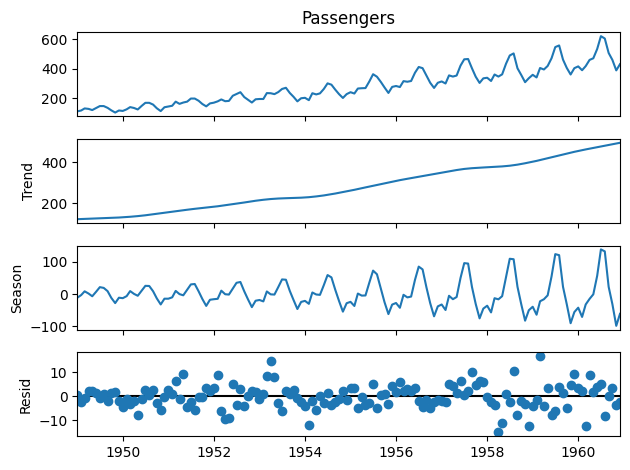

<Figure size 1200x500 with 0 Axes>

In [7]:
res.plot()
plt.figure(figsize=(12,5))
plt.show()

In [8]:
res.trend

,trend
Month,
1949-01-01,122.633476
1949-02-01,123.345101
1949-03-01,124.056118
1949-04-01,124.768936
1949-05-01,125.487065
...,...
1960-08-01,481.365377
1960-09-01,484.943608
1960-10-01,488.497348


In [9]:
res.seasonal

,season
Month,
1949-01-01,-11.022168
1949-02-01,-2.838617
1949-03-01,8.878317
1949-04-01,2.087211
1949-05-01,-6.443116
...,...
1960-08-01,132.961821
1960-09-01,22.892493
1960-10-01,-31.035689


In [10]:
res.resid

,resid
Month,
1949-01-01,0.388692
1949-02-01,-2.506484
1949-03-01,-0.934435
1949-04-01,2.143853
1949-05-01,1.956051
...,...
1960-08-01,-8.327198
1960-09-01,0.163900
1960-10-01,3.538341


## Check Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
adfullertest = adfuller(df['Passengers'], autolag='AIC')

In [13]:
adftest_output = pd.Series(adfullertest[0:4], index=['Test Statistic', 'p-value', '#Lag Used', 'Number of observations Used'])
for key, value in adfullertest[4].items():
  adftest_output['Critical Value (%s)' %key] = value

adftest_output


,0
Test Statistic,0.815369
p-value,0.991880
#Lag Used,13.000000
Number of observations Used,130.000000
Critical Value (1%),-3.481682
Critical Value (5%),-2.884042
Critical Value (10%),-2.578770


In [14]:
from statsmodels.tsa.stattools import kpss

In [15]:
kpsstest = kpss(df['Passengers'], regression='ct', nlags='auto')

In [16]:
kpsstest_output = pd.Series(kpsstest[0:3], index = ['Test Statistic', 'p-value', '#Lags Used'])
for key, value in kpsstest[3].items():
  kpsstest_output['Critical Value (%s)' %key] = value
kpsstest_output

,0
Test Statistic,0.09615
p-value,0.10000
#Lags Used,4.00000
Critical Value (10%),0.11900
Critical Value (5%),0.14600
Critical Value (2.5%),0.17600
Critical Value (1%),0.21600


In [17]:
# Print Results

adf_p = adftest_output['p-value']
kpss_p = kpsstest_output['p-value']

print("📊 Stationarity Test Results")
print(f"ADF (Original):     p = {adf_p:.4f} → {'Non-stationary' if adf_p > 0.05 else 'Stationary'}")
print(f"KPSS (Original):    p = {kpss_p :.4f} → {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")

📊 Stationarity Test Results
ADF (Original):     p = 0.9919 → Non-stationary
KPSS (Original):    p = 0.1000 → Stationary


## Make Data Stationarity

* differencing
* detrending
* np.log, np.sqrt, boxcox transformation if low variance

### Differencing

In [18]:
df['diff_12'] = df['Passengers'].diff(periods=12)

In [19]:
df.head(15)

,Passengers,diff_12
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
1949-06-01,135,NaN
1949-07-01,148,NaN
1949-08-01,148,NaN
1949-09-01,136,NaN


In [20]:
# ADF Test
adftest = adfuller(df['diff_12'].dropna(), autolag='AIC')

In [21]:
adf_p = adftest[1]

In [22]:
# KPSS Test
kpsstest = kpss(df['diff_12'].dropna(), regression = 'ct', nlags='auto')

In [23]:
kpss_p = kpsstest[1]

In [24]:
# Print the result

print("📊 Stationarity Test Results")
print(f"ADF (Original):     p = {adf_p:.4f} → {'Non-stationary' if adf_p > 0.05 else 'Stationary'}")
print(f"KPSS (Original):    p = {kpss_p :.4f} → {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")

📊 Stationarity Test Results
ADF (Original):     p = 0.0116 → Stationary
KPSS (Original):    p = 0.1000 → Stationary


<Axes: xlabel='Month'>

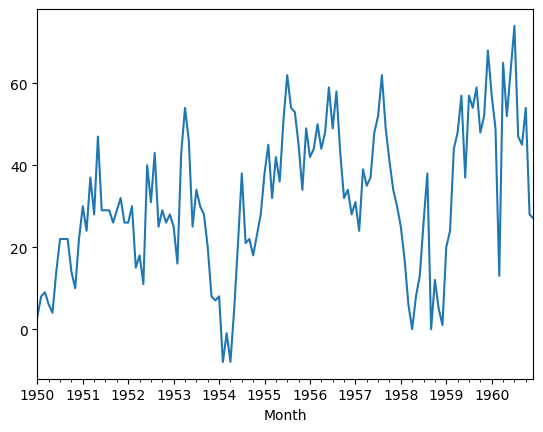

In [25]:
df['diff_12'].dropna().plot()

### Detrending

Option 1:

In [26]:
df['Detrended'] = df['Passengers']- res.trend

In [27]:
df.head()

,Passengers,diff_12,Detrended
Month,,,
1949-01-01,112,NaN,-10.633476
1949-02-01,118,NaN,-5.345101
1949-03-01,132,NaN,7.943882
1949-04-01,129,NaN,4.231064
1949-05-01,121,NaN,-4.487065


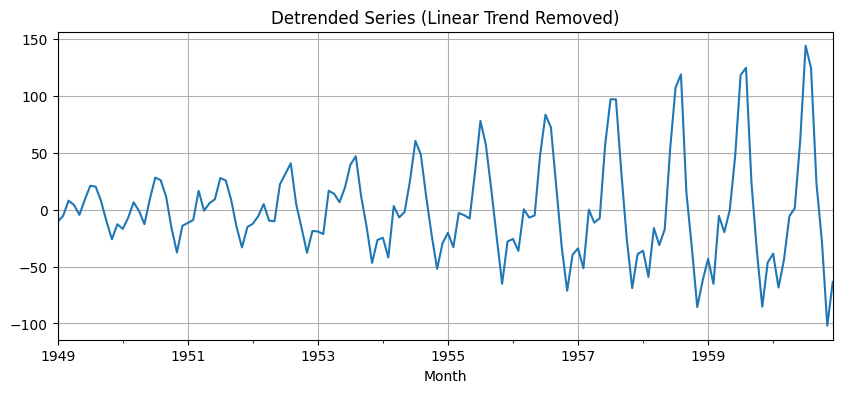

In [28]:
# Plot detrended series
df['Detrended'].plot(title='Detrended Series (Linear Trend Removed)', figsize=(10,4))
plt.grid()
plt.show()

Option 2:

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
X = np.arange(len(df)).reshape(-1,1)    # Time as feature
y = df['Passengers'].values             # Passenger values

model = LinearRegression().fit(X,y)
trend = model.predict(X)

In [31]:
df['Detrended_sklearn'] = y - model.predict(X)

In [32]:
df.head()

,Passengers,diff_12,Detrended,Detrended_sklearn
Month,,,,
1949-01-01,112,NaN,-10.633476,21.690038
1949-02-01,118,NaN,-5.345101,25.032854
1949-03-01,132,NaN,7.943882,36.375670
1949-04-01,129,NaN,4.231064,30.718487
1949-05-01,121,NaN,-4.487065,20.061303


Imagine your data trend behaves like this:

 $y_{t} = 50 + 2t + 0.05t^2 + noise$


 * Linear regression removes only `50+2t`.
 * STL removes `50+2t+0.05t^2`.

 So STL's "trend" captures the slow acceleration (`0.05t^2`) that Linear Regression ignores-- leading to slightly different detrended values.

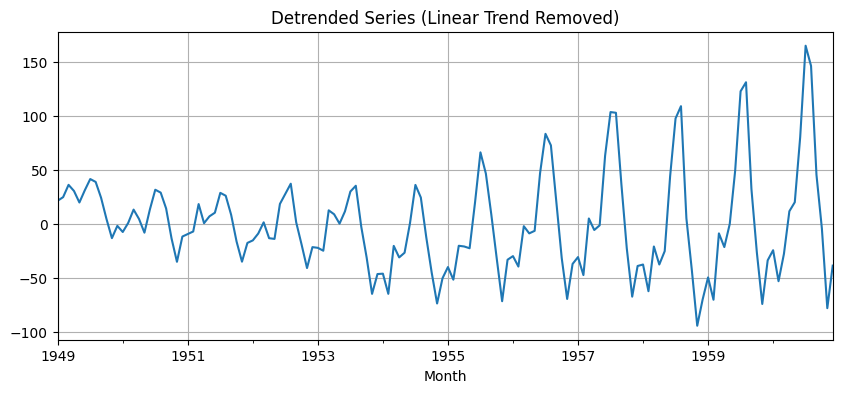

In [33]:
# Plot detrended series
df['Detrended_sklearn'].plot(title='Detrended Series (Linear Trend Removed)', figsize=(10,4))
plt.grid()
plt.show()

In [34]:
# Print the result

# ADF Test
result = adfuller(df['Detrended_sklearn'], autolag='AIC')
adf_p = result[1]

# KPSS Test
result = kpss(df['Detrended_sklearn'], regression = 'ct', nlags='auto')
kkpss_p = result[1]

print("📊 Stationarity Test Results")
print(f"ADF (Original):     p = {adf_p:.4f} → {'Non-stationary' if adf_p > 0.05 else 'Stationary'}")
print(f"KPSS (Original):    p = {kpss_p :.4f} → {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")

📊 Stationarity Test Results
ADF (Original):     p = 0.2437 → Non-stationary
KPSS (Original):    p = 0.1000 → Stationary


# AR model
$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

to predict today ($y_t$) how many past days data you want to include


### train test split

In [35]:
df['diff_12'].dropna().shape

(132,)

In [36]:
144 * 0.2

28.8

In [37]:
# Set one  year for testing
train = df.iloc[:-28]
test = df.iloc[-28:]

In [38]:
train

,Passengers,diff_12,Detrended,Detrended_sklearn
Month,,,,
1949-01-01,112,NaN,-10.633476,21.690038
1949-02-01,118,NaN,-5.345101,25.032854
1949-03-01,132,NaN,7.943882,36.375670
1949-04-01,129,NaN,4.231064,30.718487
1949-05-01,121,NaN,-4.487065,20.061303
...,...,...,...,...
1958-04-01,348,0.0,-31.093344,-37.257375
1958-05-01,363,8.0,-17.247898,-24.914559
1958-06-01,435,13.0,53.292833,44.428257


In [39]:
from statsmodels.tsa.ar_model import AutoReg

In [40]:
model = AutoReg(train['diff_12'].dropna(), lags=1)
res = model.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                diff_12   No. Observations:                  104
Model:                     AutoReg(1)   Log Likelihood                -375.738
Method:               Conditional MLE   S.D. of innovations              9.291
Date:                Wed, 12 Nov 2025   AIC                            757.475
Time:                        23:35:52   BIC                            765.380
Sample:                    02-01-1950   HQIC                           760.677
                         - 08-01-1958                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4273      1.928      3.333      0.001       2.648      10.206
diff_12.L1     0.7907      0.058     13.553      0.000       0.676       0.905
                                    Roots           

In [41]:
# one-step ahead forecast
pred = res.predict(start=len(train['diff_12'].dropna()), end=len(train['diff_12'].dropna()))
print("Next prediction:", pred.values)

Next prediction: [36.47454033]


In [42]:
# Predictions (for test period)
pred = res.predict(start= len(train['diff_12'].dropna()),
                   end = len(train['diff_12'].dropna()) + len(test) - 1)

# Align index for plotting
pred.index = test.index


In [43]:
pred.tail()     # Differenced predicted values

,0
Month,
1960-08-01,30.737052
1960-09-01,30.731608
1960-10-01,30.727304
1960-11-01,30.723900
1960-12-01,30.721209


In [44]:
# Invert differencing
pred_inverted = pred + df['Passengers'].shift(12).loc[pred.index]

# So that I can get the actual predicted values to compare with original values.


In [45]:
pred_inverted.tail()        # Actual predicted values to compare with origine one

,0
Month,
1960-08-01,589.737052
1960-09-01,493.731608
1960-10-01,437.727304
1960-11-01,392.723900
1960-12-01,435.721209


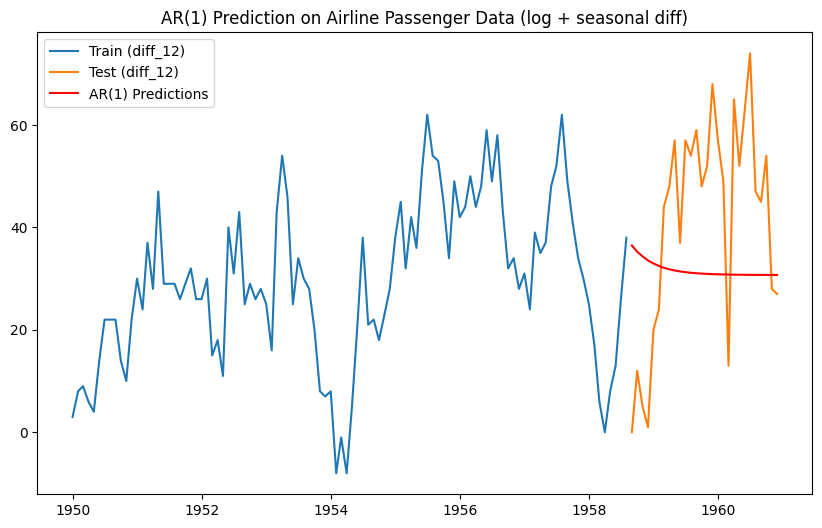

In [46]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(train['diff_12'], label = 'Train (diff_12)')
plt.plot(test['diff_12'], label = 'Test (diff_12)')
plt.plot(pred, label = 'AR(1) Predictions', color = 'red')
plt.title("AR(1) Prediction on Airline Passenger Data (log + seasonal diff)")
plt.legend()
plt.show()

**(a) Blue Segment (Train)**

* Shows the differenced values of the training portion.

* You can see ups and downs — these are changes (not actual passenger counts).

* High spikes → large increases compared to the same month in the previous year.

* Deep drops → large decreases compared to the same month last year.

So it tells how the rate of change compared to last year behaved.

**(b) Orange Segment (Test)**

* Represents unseen data that we’re testing the model on.


**(c) Red Line (Predictions)**

* The AR(1) model tries to predict future differenced values using only the last observation.

* The red curve here looks flat and underfitted — it doesn’t capture the variations seen in the orange test region.

* That tells you:

      * A simple AR(1) model (lag=1) might be too simple for this dataset.

      *  The model predicts values close to the mean of the last few observations instead of responding dynamically.

Notes:

* Red line is flat --
Model fails to capture time-dependent fluctuations.

* Predicted values don’t follow test pattern --  Model is underfitted — needs more lags or a more complex structure.

Instead of AutoReg, we can use ARIMA(1,0,0) also, both are approximately same.

In [47]:
# ARIMA(1,0,0) and AutoReg(lags=1) is approximately same in the implementation
# ARIMA -- uses Maximum Likelihood Estimation,   AutoReg(lags=1) -- uses Oridinary Least Square

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['diff_12'].dropna(), order=(1,0,0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  104
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -380.878
Date:                Wed, 12 Nov 2025   AIC                            767.755
Time:                        23:35:53   BIC                            775.688
Sample:                    01-01-1950   HQIC                           770.969
                         - 08-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.5367      4.422      6.453      0.000      19.870      37.204
ar.L1          0.8045      0.061     13.252      0.000       0.686       0.923
sigma2        87.9411     13.334      6.595      0.0

Series length (after dropna): 132


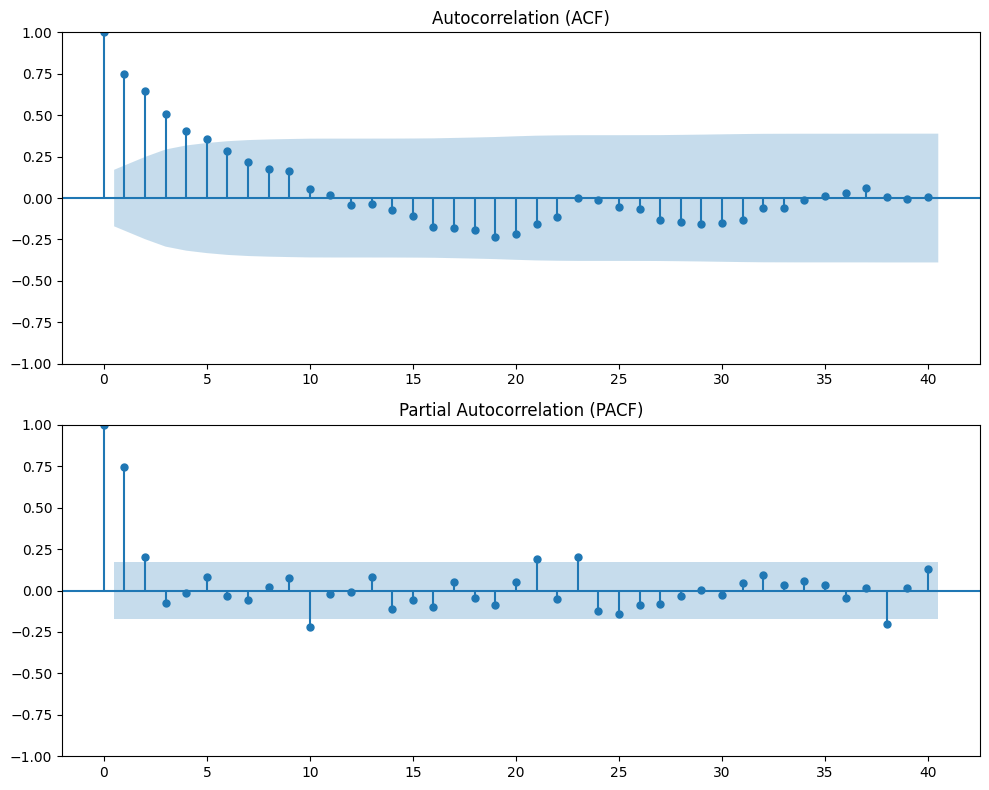

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use your stationary series (seasonally-differenced)
series = df['diff_12'].dropna()

# Quick sanity check
print("Series length (after dropna):", len(series))

# Create figure with two axes (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(10,8))

# Plot ACF on axes[0]
plot_acf(series, lags=40, ax=axes[0], alpha=0.05)   # alpha for 95% CI shading
axes[0].set_title("Autocorrelation (ACF)")

# Plot PACF on axes[1]
plot_pacf(series, lags=40, ax=axes[1], method='ywm')  # try 'ywm' or 'ols' if you prefer
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()


In [49]:
series = df['diff_12'].dropna()

# search for best lag
best_aic = np.inf
best_lag = None
best_model = None

for lag in range(1, 25):    #try lags 1 to 24
    try:
      model = AutoReg(series, lags=lag, old_names=False)
      res = model.fit()
      if res.aic < best_aic:
        best_aic = res.aic
        best_lag = lag
        best_model = res
    except Exception as e:
      continue

print(f"Best lag = {best_lag}, AIC = {best_aic}")
print(best_model.summary())


Best lag = 24, AIC = 853.9093004661454
                            AutoReg Model Results                             
Dep. Variable:                diff_12   No. Observations:                  132
Model:                    AutoReg(24)   Log Likelihood                -400.955
Method:               Conditional MLE   S.D. of innovations              9.911
Date:                Wed, 12 Nov 2025   AIC                            853.909
Time:                        23:35:55   BIC                            923.645
Sample:                    01-01-1952   HQIC                           882.184
                         - 12-01-1960                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.8662      4.302      2.061      0.039       0.435      17.298
diff_12.L1      0.7221      0.094      7.683      0.000       0.538       0.906
diff_12.L

Formula

AIC=2k-2ln(L)

Where:

k = number of estimated parameters in the model
L = maximum value of the likelihood function for the model

Best lag = 24, AIC = 614.9077909991277


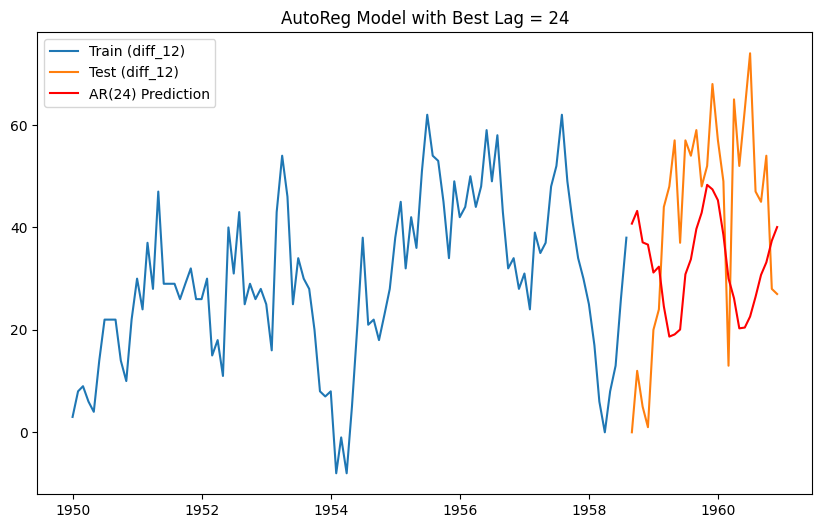

In [50]:
train_series = train['diff_12'].dropna()
test_series = test['diff_12'].dropna()

#-----Grid Search for Best Lag -------
best_aic = np.inf
best_lag = None
best_model = None

for lag in range(1, 25):     # try lags 1 to 24
  try:
    model = AutoReg(train_series, lags=lag, old_names=False)
    res = model.fit()
    if res.aic < best_aic:
      best_aic = res.aic
      best_lag = lag
      best_model = res
  except Exception:
    continue

print(f"Best lag = {best_lag}, AIC = {best_aic}")
#print(best_model.summary())


# -------Prediction -------

pred = best_model.predict(
    start = len(train_series),
    end = len(train_series) + len(test_series) - 1)


# Align indices
pred.index = test_series.index

# -----Plot ------
plt.figure(figsize=(10,6))
plt.plot(train_series, label = "Train (diff_12)")
plt.plot(test_series, label = "Test (diff_12)")
plt.plot(pred, label = f"AR({best_lag}) Prediction", color = "red")
plt.title(f"AutoReg Model with Best Lag = {best_lag}")
plt.legend()
plt.show()

# Moving Average

$y_{t} = \mu + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \dots + \theta_{p}\epsilon_{t-p} + \varepsilon_{t}$

In [51]:
from statsmodels.tsa.arima.model import ARIMA
# Fit MA(1)

ma_model = ARIMA(train_series, order=(0,0,1))   # AR = 0, differencing =0, MA=1
ma_res = ma_model.fit()
print(ma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                diff_12   No. Observations:                  104
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -406.605
Date:                Wed, 12 Nov 2025   AIC                            819.209
Time:                        23:35:56   BIC                            827.143
Sample:                    01-01-1950   HQIC                           822.423
                         - 08-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1135      1.829     15.913      0.000      25.528      32.699
ma.L1          0.5660      0.086      6.545      0.000       0.396       0.735
sigma2       145.1429     23.544      6.165      0.0

In [52]:
train_series.mean(), ma_res.params['const']

(np.float64(29.173076923076923), np.float64(29.11347509007939))

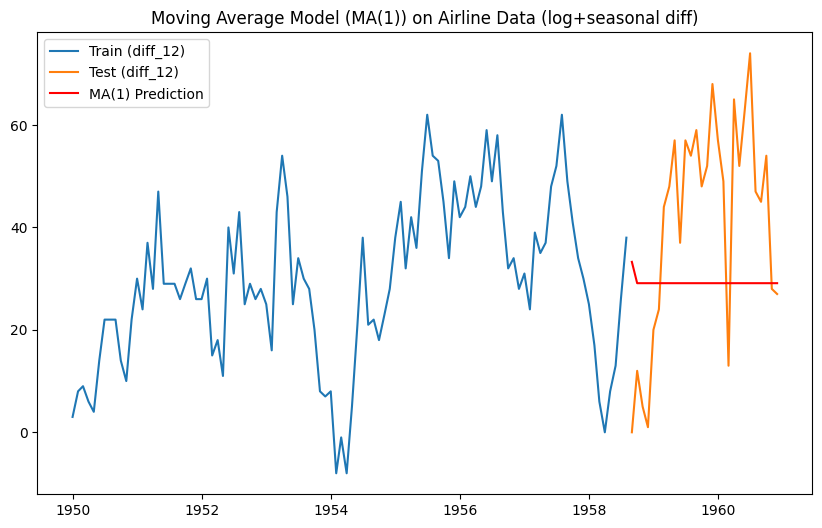

In [53]:
# Forecast into test period
ma_pred = ma_res.predict(start = len(train_series),
                         end=len(train_series) + len(test_series) - 1)

# Align index
ma_pred.index  = test_series.index

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_series, label = "Train (diff_12)")
plt.plot(test_series, label = "Test (diff_12)")
plt.plot(ma_pred, label="MA(1) Prediction", color = 'red')
plt.title("Moving Average Model (MA(1)) on Airline Data (log+seasonal diff)")
plt.legend()
plt.show()

# ARIMA

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  116
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -528.084
Date:                Thu, 13 Nov 2025   AIC                           1066.169
Time:                        00:00:49   BIC                           1079.894
Sample:                    01-01-1949   HQIC                          1071.740
                         - 08-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3396      0.148      2.298      0.022       0.050       0.629
ar.L2          0.2626      0.166      1.580      0.114      -0.063       0.588
ma.L1         -0.0104      0.115     -0.090      0.9

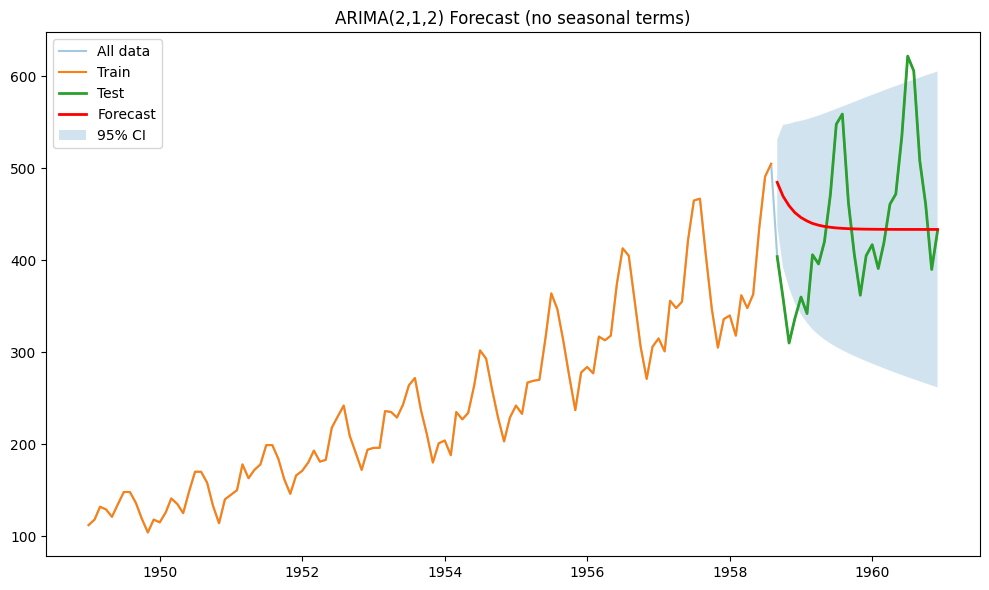

In [65]:
# Fit ARIMA model (example: ARIMA(2,1,2))
# d=1 for trend differencing, p and q chosen manually here
model = ARIMA(train['Passengers'], order=(2,1,2))
res = model.fit()
print(res.summary())

# Forcast test horizon
steps = len(test)
fc = res.get_forecast(steps=steps)
pred = fc.predicted_mean
conf_int = fc.conf_int()
pred.index = test.index
conf_int.index = test.index

# Evaluation
y_true = test['Passengers']
mse = mean_squared_error(y_true, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

# 6) Plot
plt.figure(figsize=(10,6))
plt.plot(df['Passengers'], label="All data", alpha=0.4)
plt.plot(train.index, train['Passengers'], label="Train")
plt.plot(test.index, test['Passengers'], label="Test", lw=2)
plt.plot(pred.index, pred, label="Forecast", lw=2, color="red")
plt.fill_between(pred.index, conf_int['lower Passengers'], conf_int['upper Passengers'],
                 alpha=0.2, label="95% CI")
plt.title("ARIMA(2,1,2) Forecast (no seasonal terms)")
plt.legend()
plt.tight_layout()
plt.show()
